### Izzet Emre Kucukkaya
# CMPE597 HW1

### Read dataset

In [1]:
from tensorflow.keras import datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
from CNN_Class import Network_Model, Conv2D_Layer, MaxPooling2D_Layer, FC_Layer, default_lr, cross_entropy, Softmax_Layer, lr_scheduler

In [72]:
# MNIST dataset

dataset = datasets.mnist.load_data(path="mnist.npz")
X_train = dataset[0][0]
Y_train = dataset[0][1]
X_test = dataset[1][0]
Y_test = dataset[1][1]

X_train = np.array(X_train.astype("float32") / 255) - 0.5
X_test = np.array(X_test.astype("float32") / 255) - 0.5

X_train = np.expand_dims(X_train, 1)
X_test = np.expand_dims(X_test, 1)

#train_set = [[x,y] for x, y in zip(X_train, Y_train)]
#test_set = [[x,y] for x, y in zip(X_test, Y_test)]
#print(test_set)



root = './data'
if not os.path.exists(root):
    os.mkdir(root)
    
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((-0.5,), (0.5,))])
# if not exist, download mnist dataset
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

batch_size = 100

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=60000,
                shuffle=False)
print(train_set.data.shape)


torch.Size([60000, 28, 28])


### Using Own Implementation with lr=0.001

In [3]:
# CNN Model
model = Network_Model(cross_entropy, default_lr)
model.add(Conv2D_Layer(channels=4, stride=1, kernel_size=5, activation="relu"))
model.add(MaxPooling2D_Layer(size=2))
model.add(Conv2D_Layer(channels=8, stride=1, kernel_size=5, activation="relu"))
model.add(MaxPooling2D_Layer(size=2))
model.add(FC_Layer(innode=128, outnode=128, activation="relu"))
model.add(FC_Layer(innode=128, outnode=10, activation=None))
model.add(Softmax_Layer())
model.train(X_train, Y_train, X_test, Y_test, epochs=1, lr=0.001, verbose=True)


 ==> Epoch 0
loss: 0.8496868569922696 accuracy: 72.52 val_loss: 0.3427774430097381 val_accuracy: 89.12 


In [4]:
# Simple Model Using 2 FC Layers
model = Network_Model(cross_entropy, default_lr)
model.add(FC_Layer(innode=784, outnode=128, activation="relu"))
model.add(FC_Layer(innode=128, outnode=10, activation=None))
model.add(Softmax_Layer())
model.train(X_train, Y_train, X_test, Y_test, epochs=1, lr=0.001, verbose=True)


 ==> Epoch 0
loss: 1.268726570460975 accuracy: 70.94833333333334 val_loss: 0.5366752182892833 val_accuracy: 84.89 


### Using pytorch

In [79]:
class PytorchNetwork(nn.Module):
    def __init__(self):
      super(PytorchNetwork, self).__init__()

      self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1)
      self.pool1 = nn.MaxPool2d(2)
    
      self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=5, stride=1)
      self.pool2 = nn.MaxPool2d(2)
    
      self.fc1 = nn.Linear(128, 128)
      self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
      x = self.conv1(x)
      x = F.relu(x)
      x = self.pool1(x)
    
      x = self.conv2(x)
      x = F.relu(x)
      x = self.pool2(x)
      
      x = torch.flatten(x, 1)

      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)

      output = F.log_softmax(x, dim=1)
      return output

model = PytorchNetwork()
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

PytorchNetwork(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [80]:
for epoch in range(1):
    # trainning
    total_loss = 0
    model.train()
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        x, target = Variable(x), Variable(target)
        out = model(x)
        loss = criterion(out, target)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        if (batch_idx+1) % 100 == 0 or (batch_idx+1) == len(train_loader):
            print('==>>> epoch: {}, batch index: {}, train loss: {:.6f}'.format(
                epoch, batch_idx+1, total_loss  / (batch_idx+1)))
    # testing
    model.eval()
    correct_cnt = 0
    total_cnt = 0
    total_loss = 0
    for batch_idx, (x, target) in enumerate(test_loader):
        x, target = Variable(x), Variable(target)
        out = model(x)
        loss = criterion(out, target)
        _, pred_label = torch.max(out.data, 1)
        total_cnt += x.data.size()[0]
        correct_cnt += (pred_label == target.data).sum()
        total_loss += loss.item()
        print('==>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}'.format(
            epoch, batch_idx+1, total_loss, correct_cnt * 1.0 / len(x)))

==>>> epoch: 0, batch index: 100, train loss: 1.567751
==>>> epoch: 0, batch index: 200, train loss: 0.969617
==>>> epoch: 0, batch index: 300, train loss: 0.721266
==>>> epoch: 0, batch index: 400, train loss: 0.586809
==>>> epoch: 0, batch index: 500, train loss: 0.500713
==>>> epoch: 0, batch index: 600, train loss: 0.439780
==>>> epoch: 0, batch index: 1, test loss: 0.109147, acc: 0.963


### Q2

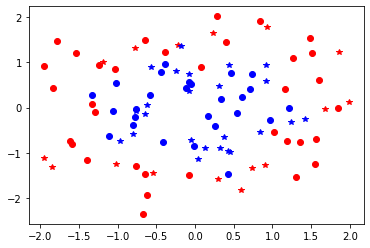

In [47]:
# Loading Dataset
X_test = np.asarray(np.load("./Data/X_test.npy"), dtype=np.float32)
X_train = np.asarray(np.load("./Data/X_train.npy"), dtype=np.float32)
Y_test = np.asarray(np.load("./Data/Y_test.npy"))
Y_train = np.asarray(np.load("./Data/Y_train.npy"))

# Find boundaries
X_grid = np.zeros((10000,2), dtype=np.float32)

for i in range(100):
    X_grid[i*100:(i+1)*100, 0] = np.linspace(-2,2,100)
    X_grid[i*100:(i+1)*100, 1] = -2 + i / 25
        
# Plot Data
plt.plot(X_test[Y_test == 0, 0], X_test[Y_test == 0, 1], "*r")
plt.plot(X_test[Y_test == 1, 0], X_test[Y_test == 1, 1], "*b")
plt.plot(X_train[Y_train == 0, 0], X_train[Y_train == 0, 1], "or")
plt.plot(X_train[Y_train == 1, 0], X_train[Y_train == 1, 1], "ob")

In [48]:
# Add data to DataLoader
batch_size = 1

train_loader = torch.utils.data.DataLoader(
                 dataset=[(x,y) for x, y in zip(X_train, Y_train)],
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=[(x,y) for x, y in zip(X_test, Y_test)],
                batch_size=len(Y_test),
                shuffle=False)
grid_loader = torch.utils.data.DataLoader(
                dataset = [(x,0) for x in X_grid],
                batch_size = len(X_grid)
                )

In [65]:
# Pytorch Model
class PytorchNetworkQ2(nn.Module):
    def __init__(self):
      super(PytorchNetworkQ2, self).__init__()
    
      self.fc1 = nn.Linear(2, 8)
      self.fc2 = nn.Linear(8, 8)
      self.fc3 = nn.Linear(8, 2)
    
    def forward(self, x):
      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)
      x = F.relu(x)
      x = self.fc3(x)
        
      return torch.sigmoid(x)

model2 = PytorchNetworkQ2()
print(model2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)

PytorchNetworkQ2(
  (fc1): Linear(in_features=2, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=2, bias=True)
)


In [66]:
for epoch in range(20):
    # trainning
    total_loss = 0
    model2.train()
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        out = model2(x)
        loss = criterion(out, target)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        if (batch_idx+1) % 100 == 0 or (batch_idx+1) == len(train_loader):
            print('==>>> epoch: {}, batch index: {}, train loss: {:.6f}'.format(
                epoch, batch_idx+1, total_loss/(batch_idx+1) / len(x)))
    # testing
    model2.eval()
    correct_cnt, total_loss = 0, 0
    total_cnt = 0
    for batch_idx, (x, target) in enumerate(test_loader):
        x, target = Variable(x), Variable(target)
        out = model2(x)
        
        loss = criterion(out, target)
        _, pred_label = torch.max(out.data, 1)
        total_cnt += x.data.size()[0]
        correct_cnt += (pred_label == target.data).sum()
        total_loss += loss.item()
        if(batch_idx+1) % 100 == 0 or (batch_idx+1) == len(test_loader):
            print('==>>> epoch: {}, batch index: {}, test loss: {:.6f}, test acc: {:.3f}'.format(
                epoch, batch_idx+1, total_loss, correct_cnt * 1.0 / total_cnt))

==>>> epoch: 0, batch index: 60, train loss: 0.695006
==>>> epoch: 0, batch index: 1, test loss: 0.692410, test acc: 0.500
==>>> epoch: 1, batch index: 60, train loss: 0.689953
==>>> epoch: 1, batch index: 1, test loss: 0.696931, test acc: 0.400
==>>> epoch: 2, batch index: 60, train loss: 0.683911
==>>> epoch: 2, batch index: 1, test loss: 0.702573, test acc: 0.400
==>>> epoch: 3, batch index: 60, train loss: 0.676139
==>>> epoch: 3, batch index: 1, test loss: 0.706750, test acc: 0.400
==>>> epoch: 4, batch index: 60, train loss: 0.674450
==>>> epoch: 4, batch index: 1, test loss: 0.717484, test acc: 0.400
==>>> epoch: 5, batch index: 60, train loss: 0.667350
==>>> epoch: 5, batch index: 1, test loss: 0.713151, test acc: 0.400
==>>> epoch: 6, batch index: 60, train loss: 0.662499
==>>> epoch: 6, batch index: 1, test loss: 0.710951, test acc: 0.400
==>>> epoch: 7, batch index: 60, train loss: 0.655847
==>>> epoch: 7, batch index: 1, test loss: 0.701354, test acc: 0.400
==>>> epoch: 8, 

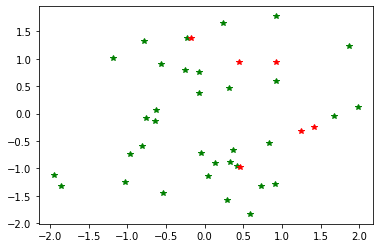

In [67]:
#True Predictions Green - Wrong Predictions Red
for i, (x, k) in enumerate(grid_loader):
    pred_label_grid = model2(x)
    _, pred_label_grid = torch.max(pred_label_grid.data, 1)
boolarray = np.array([x == y for x,y in zip(Y_test, pred_label)])
plt.plot(X_test[boolarray, 0], X_test[boolarray, 1], "*g")
plt.plot(X_test[boolarray == 0, 0], X_test[boolarray == 0, 1], "*r")

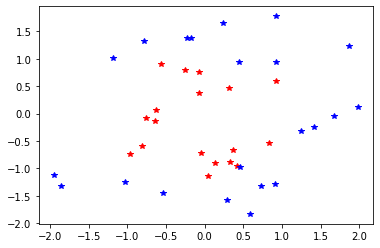

In [68]:
# Predictions
plt.plot(X_test[pred_label == 1, 0], X_test[pred_label == 1, 1], "*r")
plt.plot(X_test[pred_label == 0, 0], X_test[pred_label == 0, 1], "*b")

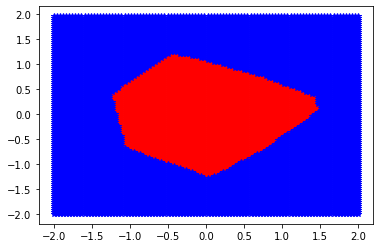

In [69]:
# Decision Boundaries
plt.plot(X_grid[pred_label_grid == 1, 0], X_grid[pred_label_grid == 1, 1], "*r")
plt.plot(X_grid[pred_label_grid == 0, 0], X_grid[pred_label_grid == 0, 1], "*b")

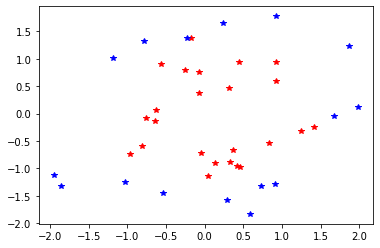

In [70]:
plt.plot(X_test[Y_test == 1, 0], X_test[Y_test == 1, 1], "*r")
plt.plot(X_test[Y_test == 0, 0], X_test[Y_test == 0, 1], "*b")